## References
- [1] Erlingsson, Pihur, and Korolova (2014) "RAPPOR: Randomized aggregatable privacy-preserving ordinal response" (ACM CCS).
- [2] Arcolezi et al (2022) "Improving the Utility of Locally Differentially Private Protocols for Longitudinal and Multidimensional Frequency Estimates" (Digital Communications and Networks).
- [3] Ding et al (2017) "Collecting telemetry data privately" (NIPS).

## Common Libraries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'20','xtick.labelsize':'20','ytick.labelsize':'20',
          'font.size':'18', 'legend.fontsize':'medium', 'lines.linewidth':'2.5', 'font.weight':'normal',
          'lines.markersize':'16', 'text.latex.preamble': r'\usepackage{amsfonts}', 'lines.markerfacecolor':'none'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from sys import maxsize
import time
import numpy as np
import xxhash
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## Importing protocols

In [2]:
# Seeding function to ensure reproducibility
from LDP.protocols import setting_seed
# Our protocols
from LDP.protocols import LOLOHA_Client, LOLOHA_Aggregator
# Competitors
from LDP.protocols import RAPPOR_Client, RAPPOR_Aggregator # [1]
from LDP.protocols import L_OSUE_Client, L_OSUE_Aggregator # [2]
from LDP.protocols import L_GRR_Client, L_GRR_Aggregator # [2]
from LDP.protocols import dBitFlipPM_Client, dBitFlipPM_Aggregator # [3]

## Reading PWGTP_Delaware dataset

In [3]:
df = pd.read_csv('datasets/PWGTP_Delaware.csv')
df.fillna(-99999, inplace=True)
df.columns = range(df.shape[1])   
df

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,167,106,100,160,85,18,22,18,94,92,...,81,101,105,22,20,20,90,154,87,20
1,22,48,24,0,24,22,0,27,72,52,...,0,31,30,27,24,25,55,65,53,67
2,0,37,37,61,37,38,32,32,66,39,...,34,0,0,62,64,0,35,71,0,31
3,32,76,35,31,39,39,67,33,36,0,...,0,70,69,0,36,68,0,0,38,32
4,61,66,128,126,121,61,0,71,190,69,...,64,167,86,1,2,2,74,87,69,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,96,17,76,78,60,57,14,15,77,40,...,67,57,14,60,65,51,73,63,52,16
9119,50,13,53,49,38,30,8,13,45,28,...,37,25,10,29,31,27,39,33,28,8
9120,191,32,201,146,155,102,38,40,157,118,...,119,153,36,135,95,122,179,91,93,36
9121,192,32,199,149,154,105,35,40,155,118,...,119,153,33,132,98,122,182,93,91,33


## Encoding

In [4]:
frac=0.05 # frac=1 for results in the paper, i.e., whole dataset
df = df.sample(frac=frac) # to decrease execution time, we'll use frac% of the dataset
df.reset_index(inplace=True, drop=True)

LE = LabelEncoder()
LE.fit_transform(np.array([val for col in df.columns for val in df[col]])) # considering all unique values

for col in df.columns:
    df[col] = LE.transform(df[col])

df

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,137,44,80,255,227,45,135,221,50,59,...,154,158,44,130,165,172,141,59,182,146
1,163,29,30,106,118,114,149,125,27,89,...,33,40,202,125,164,121,119,186,115,109
2,183,130,35,45,40,99,120,110,110,104,...,228,203,201,112,41,151,235,112,110,37
3,220,175,112,133,191,184,107,202,189,111,...,124,113,110,36,119,33,112,35,35,110
4,11,5,19,19,5,10,13,3,12,5,...,11,11,12,22,11,22,10,11,20,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,133,87,91,73,66,130,82,35,136,108,...,21,88,80,21,56,30,44,61,76,23
452,65,67,74,70,71,19,19,17,76,122,...,70,125,71,66,130,76,22,21,21,119
453,93,25,60,24,129,80,23,25,83,87,...,75,88,71,165,92,24,148,76,141,158
454,17,52,41,44,72,15,56,42,88,52,...,89,85,14,14,47,45,40,48,81,15


## Static Parameteres

In [5]:
# number of users (n)
n = df.shape[0]
print('Number of Users =',n)

# number of data collections (tau)
tau = df.shape[1]
print('Number of data collections = ', tau)

# attribute's domain size
k = len(set([val for col in df.columns for val in df[col]]))
print("\nAttribute's domain size =", k)

print('\ndBitFlipPM parameters')
b = k // 4 # Number of buckets < k
print("Number of bukects b:", b)

bulk_size = k / b
print("Bucket size:", bulk_size)

print("\nPrivacy guarantees:")

# upper bound (infinity reports)
lst_eps_perm = np.arange(0.5, 5.1, 0.5)
print("List of epsilon_perm =", lst_eps_perm)

# alpha value
alpha = 0.4
print("alpha =", alpha)

Number of Users = 456
Number of data collections =  80

Attribute's domain size = 774

dBitFlipPM parameters
Number of bukects b: 193
Bucket size: 4.010362694300518

Privacy guarantees:
List of epsilon_perm = [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
alpha = 0.4


## Real frequency

In [6]:
dic_real = {t:0 for t in range(tau)}
for t in range(tau):
    real_freq = np.zeros(k)
    for val in df[col].values:
        real_freq[val]+=1
    real_freq = real_freq / sum(real_freq)
    dic_real[t] = real_freq
dic_real

{0: array([0.01315789, 0.        , 0.00219298, 0.00877193, 0.00657895,
        0.00438596, 0.00219298, 0.00438596, 0.00657895, 0.00438596,
        0.00438596, 0.00219298, 0.00219298, 0.01096491, 0.02412281,
        0.00438596, 0.01535088, 0.01096491, 0.00438596, 0.01535088,
        0.01535088, 0.01315789, 0.00438596, 0.00657895, 0.00657895,
        0.00219298, 0.01096491, 0.01315789, 0.00877193, 0.01754386,
        0.01535088, 0.00219298, 0.01535088, 0.01535088, 0.00877193,
        0.01096491, 0.00657895, 0.00438596, 0.00438596, 0.00877193,
        0.00219298, 0.00657895, 0.00877193, 0.01096491, 0.00877193,
        0.00877193, 0.00438596, 0.00657895, 0.00438596, 0.00438596,
        0.00438596, 0.00438596, 0.        , 0.00438596, 0.        ,
        0.00877193, 0.00657895, 0.01096491, 0.00438596, 0.00657895,
        0.        , 0.00657895, 0.00219298, 0.00219298, 0.00657895,
        0.00877193, 0.00438596, 0.00219298, 0.00438596, 0.01535088,
        0.01096491, 0.00438596, 0.00219298, 0

## Take average results due to randomness

In [7]:
nb_seed = 5 # nb_seed=20 for results in the paper

# Save MSE per seed
dic_mse = {seed: 
               {"OLOLOHA": [],
                "BiLOLOHA": [],
                "L_OSUE": [],
                "RAPPOR": [],
                "L_GRR": [],
                "1BitFlipPM": [],
                "bBitFlipPM": []
               } 
               for seed in range(nb_seed)
          }
# Save budget consumption per seed
dic_bdg = {seed: 
               {"OLOLOHA": -1,
                "BiLOLOHA": -1,
                "L_OSUE": -1,
                "RAPPOR": -1,
                "L_GRR": -1,
                "1BitFlipPM": -1,
                "bBitFlipPM": -1
               } 
               for seed in range(nb_seed)
          }

# Save data change detection per seed
dic_chg = {seed: 
               {
                "1BitFlipPM": -1,
                "bBitFlipPM": -1
               } 
               for seed in range(nb_seed)
          }

## OLOLOLHA

In [9]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = LOLOHA_Client(row.values, k, eps_perm, eps_1, alpha, optimal=True)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = LOLOHA_Aggregator(reports[:, t], k, eps_perm, eps_1, alpha, optimal=True)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
    
    dic_mse[seed]["OLOLOHA"] = lst_mse_avg
    dic_bdg[seed]["OLOLOHA"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 2564.9087595939636 seconds


## BiLOLOHA

In [8]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = LOLOHA_Client(row.values, k, eps_perm, eps_1, alpha, optimal=False)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = LOLOHA_Aggregator(reports[:, t], k, eps_perm, eps_1, alpha, optimal=False)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["BiLOLOHA"] = lst_mse_avg
    dic_bdg[seed]["BiLOLOHA"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 1405.1391294002533 seconds


## L-OSUE [2]

In [10]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = L_OSUE_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = L_OSUE_Aggregator(reports[:, t], eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["L_OSUE"] = lst_mse_avg
    dic_bdg[seed]["L_OSUE"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 46.92410469055176 seconds


## RAPPOR [1]

In [12]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = RAPPOR_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = RAPPOR_Aggregator(reports[:, t], eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["RAPPOR"] = lst_mse_avg
    dic_bdg[seed]["RAPPOR"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 49.203763484954834 seconds


## L-GRR [2]

In [13]:
starttime = time.time()

for seed in range(nb_seed):
    print(seed)
    setting_seed(seed) # Ensure reproducibility
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        eps_1 = alpha * eps_perm # First report privacy guarantee (lower bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget = L_GRR_Client(row.values, k, eps_perm, eps_1)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = dic_real[0] # for Adult dataset, the real frequency is the same for all t \in [\tau]
            est_freq = L_GRR_Aggregator(reports[:, t], k, eps_perm, eps_1)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        
    dic_mse[seed]["L_GRR"] = lst_mse_avg
    dic_bdg[seed]["L_GRR"] = lst_bdg_avg
    
print('That took {} seconds'.format(time.time() - starttime))    

0
1
2
3
4
That took 11.765400648117065 seconds


## 1BitFlipPM [3]

In [14]:
starttime = time.time()

# Number of bits each user sample/report
d = 1

for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    lst_detect_change = [] # List of 100% detected change
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        change_tracking = [] # List of Boolean value indicating data change detection for all values
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget, detect_change = dBitFlipPM_Client(row.values, k, b, d, eps_perm)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
            change_tracking.append(detect_change)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = np.zeros(b)
            for val in df[t].values:
                real_freq[int(val / bulk_size)]+=1
            real_freq = real_freq/sum(real_freq)
            
            est_freq = dBitFlipPM_Aggregator(reports[:, t], b, d, eps_perm)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        lst_detect_change.append(100 * sum(change_tracking) / n) # Averaged data change detection in %
        
    dic_mse[seed]["1BitFlipPM"] = lst_mse_avg
    dic_bdg[seed]["1BitFlipPM"] = lst_bdg_avg
    dic_chg[seed]["1BitFlipPM"] = lst_detect_change
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 451.7601773738861 seconds


## bBitFlipPM [3]

In [15]:
starttime = time.time()

# Number of bits each user sample/report
d = b

for seed in range(nb_seed):
    print(seed)
    np.random.seed(seed) # Ensure reproducibility
    
    lst_mse_avg = [] # List of averaged MSE per eps_perm
    lst_bdg_avg = [] # List of averaged budget consumption per eps_perm
    lst_detect_change = [] # List of 100% detected change
    
    for eps_perm in lst_eps_perm: # Longitudinal privacy guarantee (upper bound)
        
        # Client-Side
        reports = [] # List of reports of all n users
        budget_tracking = [] # List of consumed privacy budget of all n users
        change_tracking = [] # List of Boolean value indicating data change detection for all values
        for ind, row in df.iterrows():
            
            sanitized_reports, final_budget, detect_change = dBitFlipPM_Client(row.values, k, b, d, eps_perm)
            reports.append(sanitized_reports)
            budget_tracking.append(final_budget)
            change_tracking.append(detect_change)
        
        reports = np.array(reports)
        
        # Server-Side
        lst_mse = [] # List of all MSE per data collection
        for t in range(tau): # For each data collection
            
            real_freq = np.zeros(b)
            for val in df[t].values:
                real_freq[int(val / bulk_size)]+=1
            real_freq = real_freq/sum(real_freq)
            
            est_freq = dBitFlipPM_Aggregator(reports[:, t], b, d, eps_perm)
            lst_mse.append(mean_squared_error(real_freq, est_freq))
        
        lst_mse_avg.append(np.mean(lst_mse)) # Averaged MSE
        lst_bdg_avg.append(np.mean(budget_tracking)) # Averaged privacy budget consumption
        lst_detect_change.append(100 * sum(change_tracking) / n) # Averaged data change detection in %
        
    dic_mse[seed]["bBitFlipPM"] = lst_mse_avg
    dic_bdg[seed]["bBitFlipPM"] = lst_bdg_avg
    dic_chg[seed]["bBitFlipPM"] = lst_detect_change
    
print('That took {} seconds'.format(time.time() - starttime))

0
1
2
3
4
That took 1562.2176611423492 seconds


## Plotting MSE_avg metric results

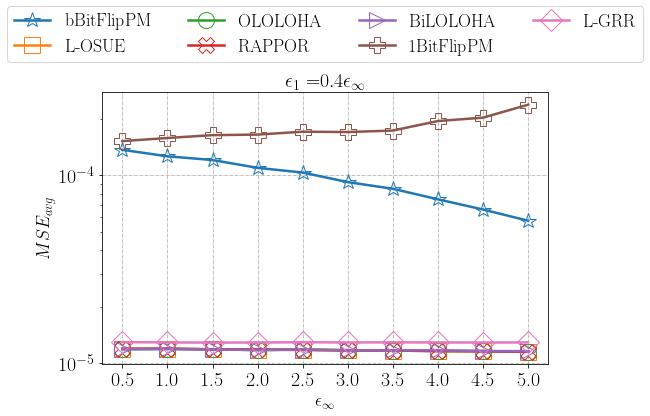

In [16]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_mse[seed]["bBitFlipPM"] for seed in range(nb_seed)], axis=0), label='bBitFlipPM', marker='*')
plt.plot(np.mean([dic_mse[seed]["L_OSUE"] for seed in range(nb_seed)], axis=0), label='L-OSUE',marker='s')
plt.plot(np.mean([dic_mse[seed]["OLOLOHA"] for seed in range(nb_seed)], axis=0), label='OLOLOHA', marker='o')
plt.plot(np.mean([dic_mse[seed]["RAPPOR"] for seed in range(nb_seed)], axis=0), label='RAPPOR',marker='X')
plt.plot(np.mean([dic_mse[seed]["BiLOLOHA"] for seed in range(nb_seed)], axis=0), label='BiLOLOHA',marker='>')
plt.plot(np.mean([dic_mse[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0), label='1BitFlipPM', marker='P')
plt.plot(np.mean([dic_mse[seed]["L_GRR"] for seed in range(nb_seed)], axis=0), label='L-GRR', marker='D')

plt.yscale('log')
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('$MSE_{avg}$')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.title('$\epsilon_1$ $=$' +f'${alpha}$'+ '$\epsilon_{\infty}$', loc='center')
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.show()

## Plotting privacy budget consumption metric results

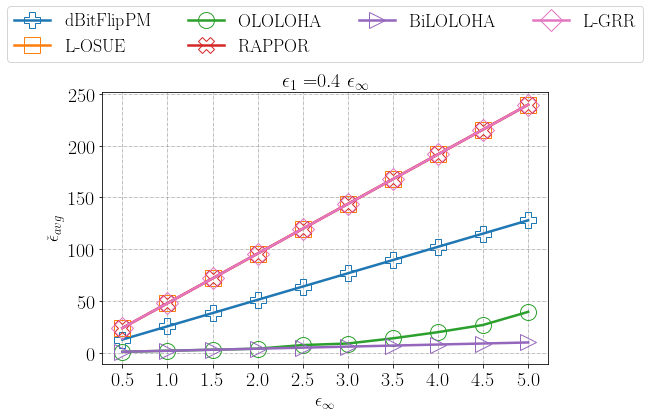

In [19]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_bdg[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='dBitFlipPM', marker='P')
plt.plot(np.mean([dic_bdg[seed]["L_OSUE"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='L-OSUE',marker='s')
plt.plot(np.mean([dic_bdg[seed]["OLOLOHA"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='OLOLOHA', marker='o')
plt.plot(np.mean([dic_bdg[seed]["RAPPOR"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='RAPPOR',marker='X')
plt.plot(np.mean([dic_bdg[seed]["BiLOLOHA"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='BiLOLOHA',marker='>')
plt.plot(np.mean([dic_bdg[seed]["L_GRR"] for seed in range(nb_seed)], axis=0)*lst_eps_perm, label='L-GRR', marker='D', color='tab:pink')


# plt.yscale('log')
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('$\check{\epsilon}_{avg}$')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.title('$\epsilon_1$ $=$' +f'${alpha}$'+ '  $\epsilon_{\infty}$', loc='center')
plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.35))
plt.show()

## Plotting data change detection for dBitFlipPM

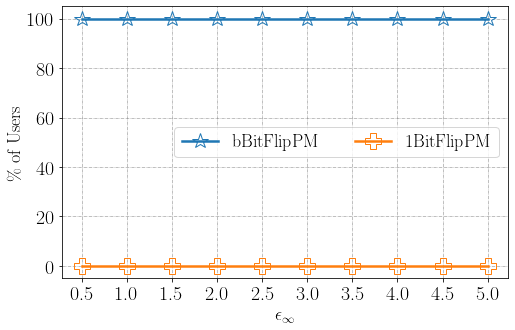

In [18]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_chg[seed]["bBitFlipPM"] for seed in range(nb_seed)], axis=0), label='bBitFlipPM', marker='*')
plt.plot(np.mean([dic_chg[seed]["1BitFlipPM"] for seed in range(nb_seed)], axis=0), label='1BitFlipPM', marker='P')
# plt.yscale('log')
plt.xlabel('$\epsilon_{\infty}$')
plt.ylabel('\% of Users')
plt.xticks(range(len(lst_eps_perm)), lst_eps_perm)
plt.legend(ncol=2)
plt.show()